<a href="https://colab.research.google.com/github/AbigailMRod/GANsDL.AI/blob/main/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bias

En este cuaderno, se explorará una manera de identificar algunos sesgos de una GAN mediante un clasificador, de una manera adecuada para intentar crear un modelo independiente de una entrada. Tenga en cuenta que no todos los sesgos son tan obvios como los que verá aquí.



## Desafíos

Un desafío importante en la evaluación del sesgo en las GAN es que aún desea que su generador pueda generar ejemplos de diferentes valores de una clase protegida, la clase contra la que le gustaría mitigar el sesgo. Si bien un clasificador se puede optimizar para que su salida sea independiente de una clase protegida, un generador que genera caras debería poder generar ejemplos de varios valores de clase protegida.

Cuando genera ejemplos con varios valores de una clase protegida, no desea que esos ejemplos correspondan a ninguna propiedad que no sea estrictamente una función de esa clase protegida. Esto se hace especialmente difícil ya que muchas clases protegidas (por ejemplo, género o etnicidad) son construcciones sociales, y qué propiedades cuentan como "una función de esa clase protegida" variará dependiendo de a quién le preguntes. Ciertamente es un equilibrio difícil de lograr.

Además, una clase protegida rara vez se usa para condicionar una GAN explícitamente, por lo que a menudo es necesario recurrir a métodos algo post-hoc (por ejemplo, usar un clasificador entrenado en características relevantes, que podría estar sesgado).

En esta tarea, aprenderá un enfoque para detectar posibles sesgos mediante el análisis de correlaciones en las clasificaciones de características en las imágenes generadas.

## Empezando

Como se ha hecho anteriormente, comenzaremos importando algunas bibliotecas útiles y definiendo una función de visualización para sus imágenes. También utilizará el mismo generador y clasificador básico de las semanas anteriores.

Paquetes y visualización

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Función de visualización de imágenes: Dado un tensor de imágenes, número de imágenes,
     tamaño por imagen e imágenes por fila, traza e imprime las imágenes en una cuadrícula uniforme.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Generador y ruido

In [2]:
class Generator(nn.Module):
    '''
    Clase de generador
     Valores:
         z_dim: la dimensión del vector de ruido, un escalar
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (CelebA es rgb, por lo que 3 es su valor predeterminado)
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque generador de DCGAN;
         una convolución transpuesta, una norma por lotes (excepto en la capa final) y una activación.
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Función para completar un paso hacia adelante del generador: Dado un tensor de ruido,
         devuelve las imágenes generadas.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Función para crear vectores de ruido: Dadas las dimensiones (n_samples, z_dim)
     crea un tensor de esa forma lleno de números aleatorios de la distribución normal.
     Parámetros:
         n_samples: el número de muestras a generar, un escalar
         z_dim: la dimensión del vector de ruido, un escalar
         device: el tipo de dispositivo
    '''
    return torch.randn(n_samples, z_dim, device=device)

Clasificador

In [3]:
class Classifier(nn.Module):
    '''
    Clase de clasificador
     Valores:
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (CelebA es rgb, por lo que 3 es su valor predeterminado)
         n_classes: el número total de clases en el conjunto de datos, un escalar entero
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque clasificador;
         una convolución, una norma por lotes (excepto en la capa final) y una activación (excepto en la capa final).
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante del clasificador: Dado un tensor de imagen,
         devuelve un tensor n_classes-dimension que representa clases.
         Parámetros:
             image: un tensor de imagen aplanado con canales im_chan
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Especificación de parámetros
También deberá especificar algunos parámetros antes de comenzar a entrenar:
   * z_dim: la dimensión del vector de ruido
   * batch_size: el número de imágenes por paso adelante/atrás
   * device: el tipo de dispositivo

In [4]:
z_dim = 64
batch_size = 128
device = 'cuda'

## Entrena a un Clasificador (Opcional)

Puede entrenar su propio clasificador con este código, pero aquí se le proporciona uno preentrenado basado en esta arquitectura que puede cargar y usar en la siguiente sección.

In [5]:
# Puede ejecutar este código para entrenar su propio clasificador, pero se proporciona uno preentrenado
# Si desea usar esto, simplemente ejecute "train_classifier (nombre de archivo)"
# Para entrenar y guardar un clasificador en los índices de etiquetas para ese nombre de archivo
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Vas a apuntar a todas las clases, así que esa es la cantidad que aprenderá el clasificador.
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Descomente la última línea para entrenar su propio clasificador: esta línea no funcionará en Coursera.
# Si desea hacer esto, deberá descargarlo y ejecutarlo, idealmente usando una GPU.
# train_classifier("nombre de archivo")

## Cargando los modelos pre-entrenados

Ahora puede cargar el generador preentrenado (entrenado en CelebA) y el clasificador usando el siguiente código. Si entrenó su propio clasificador, puede cargarlo aquí. Sin embargo, se sugiere que primero realice la tarea con la persona previamente entrenada.

In [8]:
!git clone https://github.com/AbigailMRod/GANsDL.AI.git

Cloning into 'GANsDL.AI'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 50 (delta 10), reused 20 (delta 2), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [9]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/content/GANsDL.AI/models/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/content/GANsDL.AI/models/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Correlación de funciones
Ahora puedes generar imágenes usando el generador. Al usar también el clasificador, generará imágenes con diferentes cantidades de la característica "masculina".

Le invitamos a experimentar con otras funciones como la función de destino, pero se recomienda que primero revise el cuaderno tal como está antes de explorar.

In [10]:
# Primero generas un montón de imágenes falsas con el generador.
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # Cuántos pasos de gradiente tomar
skip = 2 # Cuántos pasos de gradiente omitir en la visualización

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)
# Establecer la característica de destino
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

# Dirección aditiva (más de una característica)
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data += new_noise.grad / grad_steps

# Dirección sustractiva (menos de una característica)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history)

Ahora ha generado muestras de imágenes, que tienen cantidades crecientes o decrecientes de la función de destino. Puede visualizar la forma en que eso afecta a otras características clasificadas. El eje x le mostrará la cantidad de cambio en su característica de destino y el eje y muestra cuánto cambian las otras características, según lo detecte el clasificador en esas imágenes. Juntos, podrán ver la covarianza de la "masculinidad" y otras características.

Comenzaste con un conjunto de características que tienen asociaciones interesantes con "masculinidad", pero puedes cambiar las características en `otras_características` con otras de `feature_names`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

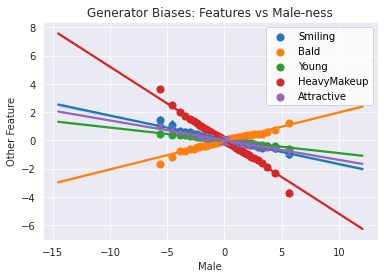

In [11]:
import seaborn as sns
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
    other_indices = feature_names.index(other_feature)
    with sns.axes_style("darkgrid"):
        sns.regplot(
            classification_changes[:, :, target_indices].reshape(-1), 
            classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

Esta detección de correlación se puede utilizar para reducir el sesgo penalizando este tipo de correlación en la pérdida durante el entrenamiento del generador. Sin embargo, actualmente no existe una solución rigurosa y aceptada para eliminar el sesgo de las GAN. Un primer paso que puede tomar en la dirección correcta es antes de entrenar el modelo: asegúrese de que su conjunto de datos sea inclusivo y representativo, y considere cómo puede mitigar los sesgos resultantes del método de recopilación de datos que utilizó, por ejemplo, obtener un representante. etiquetadoras para su tarea.

Es importante tener en cuenta que, como se destacó en la conferencia y por muchos investigadores, incluidos [Timnit Gebru y Emily Denton](https://sites.google.com/view/fatecv-tutorial/schedule), un conjunto de datos diverso por sí solo no es suficiente para eliminar el sesgo. Incluso diversos conjuntos de datos pueden reforzar los sesgos estructurales existentes simplemente capturando los sesgos sociales comunes. Mitigar estos sesgos es un área de investigación importante y activa.

#### Nota sobre CelebA
Es posible que haya notado que existen correlaciones obvias entre la característica que está utilizando, "masculino", y otras características aparentemente no relacionadas, por ejemplo, "sonriente" y "joven". Esto se debe a que las etiquetas del conjunto de datos de CelebA no consideraron seriamente la diversidad. Los datos representan los sesgos de sus etiquetadores, los creadores del conjunto de datos, los sesgos sociales como resultado del uso de un conjunto de datos basado en celebridades estadounidenses y muchos otros. Equipado con conocimiento sobre el sesgo, confiamos en que lo hará mejor en los futuros conjuntos de datos que cree.

## Cuantificación
Finalmente, también puede evaluar cuantitativamente el grado en que estos factores covarían. Dado un índice de destino, por ejemplo, correspondiente a "masculino", querrá devolver las otras características que covarían más con esa característica de destino. Querrá tener en cuenta las covarianzas positivas y negativas grandes, y querrá evitar devolver la característica de destino en su lista de características covariables (ya que una característica a menudo tendrá una alta covarianza consigo misma). Primero completará algunas funciones auxiliares, cada una de las cuales debe tener una o dos líneas de longitud.

In [12]:
from torch.distributions import MultivariateNormal
def covariance_matrix_from_examples(examples):
    """
    Función auxiliar para get_top_covariances para calcular una matriz de covarianza.
     Parámetro: ejemplos: una lista de pasos correspondientes a muestras de forma (2 * grad_steps, n_images, n_features)
     Devuelve: la matriz de covarianza (n_características, n_características) de los ejemplos
    """
    # Hint: np.cov will be useful here - note the rowvar argument!
    ### START CODE HERE ###
    flattened_examples = examples.reshape(-1, examples.shape[-1])
    return np.cov(flattened_examples, rowvar=False)
    ### END CODE HERE ###
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
samples = MultivariateNormal(mean, covariance).sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1]).numpy()
assert np.all(np.abs(covariance_matrix_from_examples(foo) - covariance.numpy()) < 0.5)
print("covariance_matrix_from_examples works!")

covariance_matrix_from_examples works!


Ahora escribirá una función auxiliar para devolver los índices de una matriz numpy en orden de magnitud.

In [13]:
def get_top_magnitude_indices(values):
    """
    Función auxiliar para get_top_covariances para obtener índices por magnitud.
     Parámetro: valores, una lista de valores como una matriz numérica de formas (n_valores)
     Devoluciones: matriz numpy de índices ordenados de mayor a menor por las magnitudes de sus valores correspondientes
    """
    # Hint: This can be done in one or two lines using np.argsort and np.abs!
    ### START CODE HERE ###
    return np.argsort(np.abs(values))[::-1]
    ### END CODE HERE ###
    return top_indices
assert get_top_magnitude_indices([3, 2, 1, 0]).tolist() == [0, 1, 2, 3]
assert get_top_magnitude_indices([-2, 0, 1]).tolist() == [0, 2, 1]
print("get_top_magnitude_indices works!")

get_top_magnitude_indices works!


Ahora escribirá una función auxiliar para devolver una lista con un elemento eliminado por el valor, en un orden sin cambios. En este caso, no tendrá que eliminar ningún valor varias veces, así que no se preocupe por cómo maneja varios ejemplos.

In [14]:
def remove_from_list(indices, index_to_remove):
    """
    Helper function for get_top_covariances to remove an index from an array. 
    Parameter: indices, a list of indices as a numpy array of shape (n_indices)
    Returns: the numpy array of indices in the same order without index_to_remove
    """
    # Sugerencia: hay muchas maneras de hacer esto, pero no edite la lista en el lugar.
     # Si no está muy familiarizado con la indexación de matrices, puede encontrar útil esta página:
     # https://numpy.org/devdocs/reference/arrays.indexing.html (especialmente la indexación booleana)
    ### START CODE HERE ###
    new_indices = np.delete(indices, np.where(indices == index_to_remove))
    ### END CODE HERE ###
    return new_indices
assert remove_from_list(np.array([3, 2, 1, 0]), 1).tolist() == [3, 2, 0]
print("remove_from_list works!")

remove_from_list works!


Ahora, puede juntar las funciones auxiliares anteriores.

In [15]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: get_top_covariances
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Función para obtener las n covarianzas principales: Dada una lista de cambios de clasificación
     y el índice de la característica de destino, devuelve
     (1) índices_relevantes: una lista o tensor (numpy o antorcha) de los índices correspondientes
         a las n características que covarían más con el objetivo en términos de covarianza absoluta
     (2) covarianzas_máximas: una lista o tensor de los grados en los que covarían.
     Parámetros:
         Classification_changes: cambios relativos en las clasificaciones de cada imagen generada
           como resultado de la optimización de la función de destino (ver arriba para una visualización)
         target_index: el índice de la característica de destino, un escalar
         top_n: la mayor cantidad de elementos para devolver, el valor predeterminado es 10
    '''
    # Sugerencia: ¡No olvide que también le importan las covarianzas negativas!
     # Tenga en cuenta que class_changes tiene una forma de (2 * grad_steps, n_images, n_features)
     # donde n_características es el número de características medidas por el clasificador, y está buscando
     # para la covarianza de las características basadas en las muestras (2 * grad_steps * n_images).
    #### START CODE HERE ####
    covariance_matrix = covariance_matrix_from_examples(classification_changes)
    relevant_indices = remove_from_list(get_top_magnitude_indices(covariance_matrix[target_index, :]), target_index)[:top_n]
    highest_covariances = covariance_matrix[:, relevant_indices][target_index]
    #### END CODE HERE ####
    return relevant_indices, highest_covariances

In [19]:
# UNIT TEST
from torch.distributions import MultivariateNormal
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1])

relevant_indices, highest_covariances = get_top_covariances(foo, 1, top_n=3)
assert (tuple(relevant_indices) == (2, 3, 0)), "Make sure you're getting the greatest, not the least covariances"
assert np.all(np.abs(highest_covariances - [5, 4, 2]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 0, top_n=3)
assert (tuple(relevant_indices) == (3, 1, 2)), "Make sure to consider the magnitude of negative covariances"
assert np.all(np.abs(highest_covariances - [-5, 2, -0.5]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 2, top_n=2)
assert (tuple(relevant_indices) == (1, 3))
assert np.all(np.abs(highest_covariances - [5, 2]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 3, top_n=2)
assert (tuple(relevant_indices) == (0, 1))
assert np.all(np.abs(highest_covariances - [-5, 4]) < 0.5 )

print("All tests passed")

All tests passed


In [21]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
relevant_indices[9] == 34
assert len(relevant_indices) == 10
assert highest_covariances[8] - (-1.2418) < 1e-3
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

[36 18 24 30  0 22 16 38 34 29]
WearingLipstick  -2.966299
HeavyMakeup  -2.749323
NoBeard  -2.547929
Sideburn  2.094072
5oClockShadow  2.091632
Mustache  2.041807
Goatee  1.880178
WearingNecktie  1.644223
WearingEarrings  -1.363953
RosyCheeks  -1.274889


Una de las principales fuentes de dificultad para identificar el sesgo y la equidad, es que hay muchas formas en las que podría definir razonablemente estos términos. Aquí hay tres formas que son computacionalmente útiles y [ampliamente referenciadas] (http://m-mitchell.com/papers/Adversarial_Bias_Mitigation.pdf). No son, de ninguna manera, las únicas definiciones de equidad (ver más detalles [aquí](https://developers.google.com/machine-learning/glossary/fairness)):


1. Paridad demográfica: la distribución global de las predicciones realizadas por un predictor es la misma para diferentes valores de una clase protegida.
2. Igualdad de probabilidades: siendo todo lo demás igual, la probabilidad de que usted prediga correctamente o incorrectamente es la misma para diferentes valores de una clase protegida.
2. Igualdad de oportunidades: en igualdad de condiciones, la probabilidad de que prediga correctamente es la misma para diferentes valores de una clase protegida (más débil que la igualdad de probabilidades).

Dado que las GAN también se utilizan para ayudar a los clasificadores posteriores (verá esto de primera mano en asignaciones futuras), estas definiciones de equidad afectarán y dependerán de su tarea posterior. Es importante trabajar para crear una GAN justa de acuerdo con la definición que elija. Perseguir cualquiera de ellos es prácticamente siempre mejor que etiquetar datos a ciegas, crear una GAN y probar sus generaciones.